In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

max_gen = 75000

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests

In [3]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:red,:green,:yellow,:blue,:pink])

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

In [4]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_1.jld2"));

In [5]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

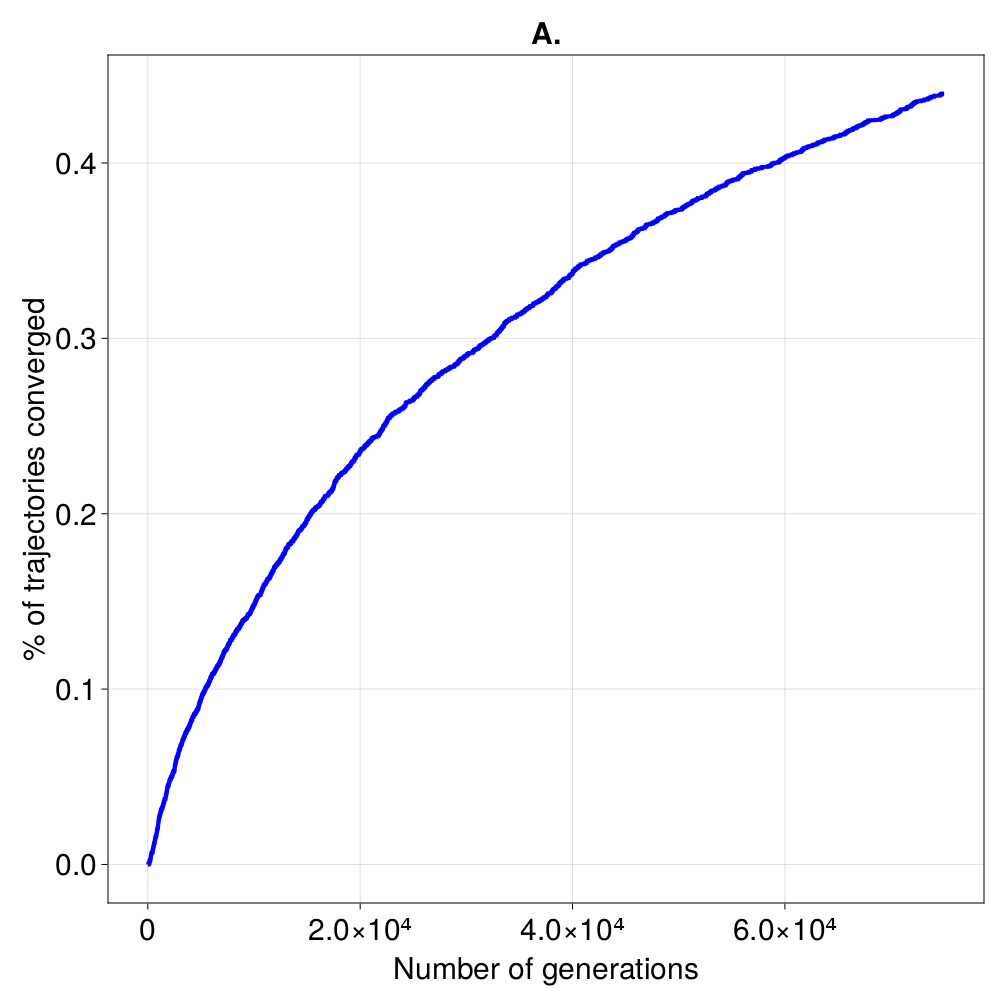

In [6]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A.",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

# CairoMakie.save(plotsdirx("MSelection","Convergence.png"),fig)

fig

In [7]:
cum_conv[end]

0.4396

In [8]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);

In [9]:
sim_m = copy(data["fund_dmat_cell"])
conv = copy(data["converged"]);

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

In [10]:
end_networks = map(v->v[:,end],data["geno_traj"]);

In [11]:
mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];


In [12]:
countmap(class_labels)

Dict{String, Int64} with 5 entries:
  "bistable"      => 30
  "feed_forward"  => 2
  "classical"     => 1043
  "mutual_inh"    => 3
  "No assignment" => 1120

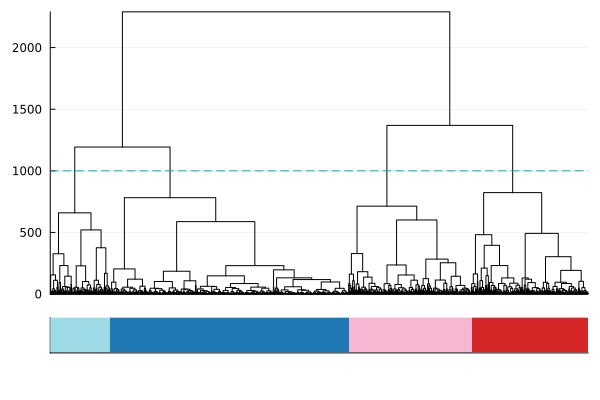

In [13]:
cu_thresh =  1000

hc1 = hclust(dmat_av[conv,conv],linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [14]:
fitness_traj = copy(data["fitness_traj"])[conv];

In [15]:
conv_time = map(x->length(x),fitness_traj) 
conv_time_n = conv_time / maximum(conv_time);

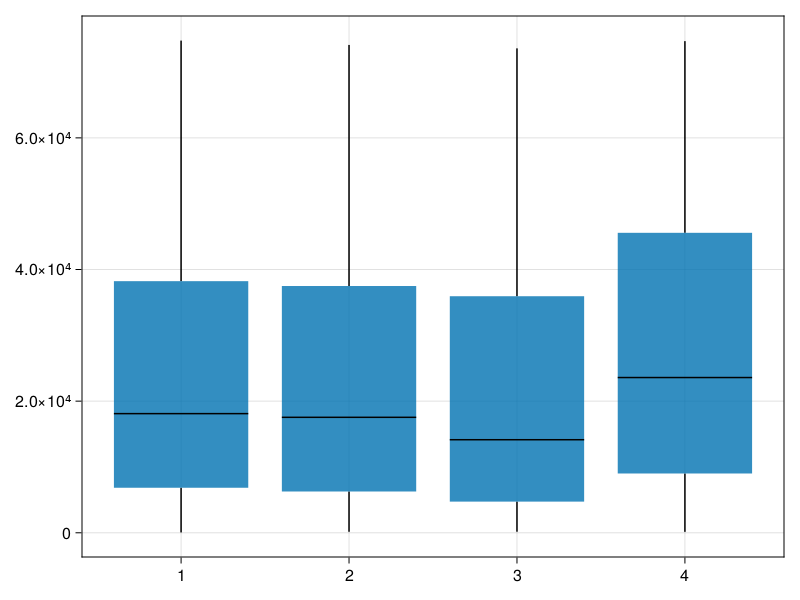

In [16]:
CairoMakie.boxplot(clust_labels, conv_time)

In [17]:
geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

In [18]:
function get_mutant_n_dist(g_traj)
    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    return sum(g_traj_diff .!= 0.,dims = 1)[1,:]
end

function get_mutant_dist(g_traj)
    g_traj_diff = (g_traj[:,2:end] .- g_traj[:,1:end-1]) ./ map(x-> x == 0 ? 1. : x, g_traj[:,1:end-1])
    
    return [filter(x->x .!= 0.,v) for v in eachcol(g_traj_diff)]
end

function get_fitness_delta(f_traj)
    f_traj_diff = f_traj[2:end] .- f_traj[1:end-1]
    return f_traj_diff
end

function get_mutation_id(g_traj)

    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    mut_id = [findall(x-> x .!= 0, y) for y in eachcol(g_traj_diff)]

    return mut_id
end


weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

In [19]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

In [20]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->unique(x)[1:end-1],fitness_traj);

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_size_label_af = [[(fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [21]:
function condition_data(return_var,condition_var,condition_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

function condition_data_incl(return_var,condition_var,condition_values,incl_var,incl_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]) & all([value ∈ x[var] for (var,value) in zip(incl_var,incl_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

condition_data_incl (generic function with 1 method)

In [22]:
r = condition_data((:mut_size,:fitness_delta),[:cluster_id],[1],all_mut_info)

r_ms = reduce(vcat,map(x->length(x),r[:mut_size]));
r_fitness_delta = reduce(vcat,r[:fitness_delta]);

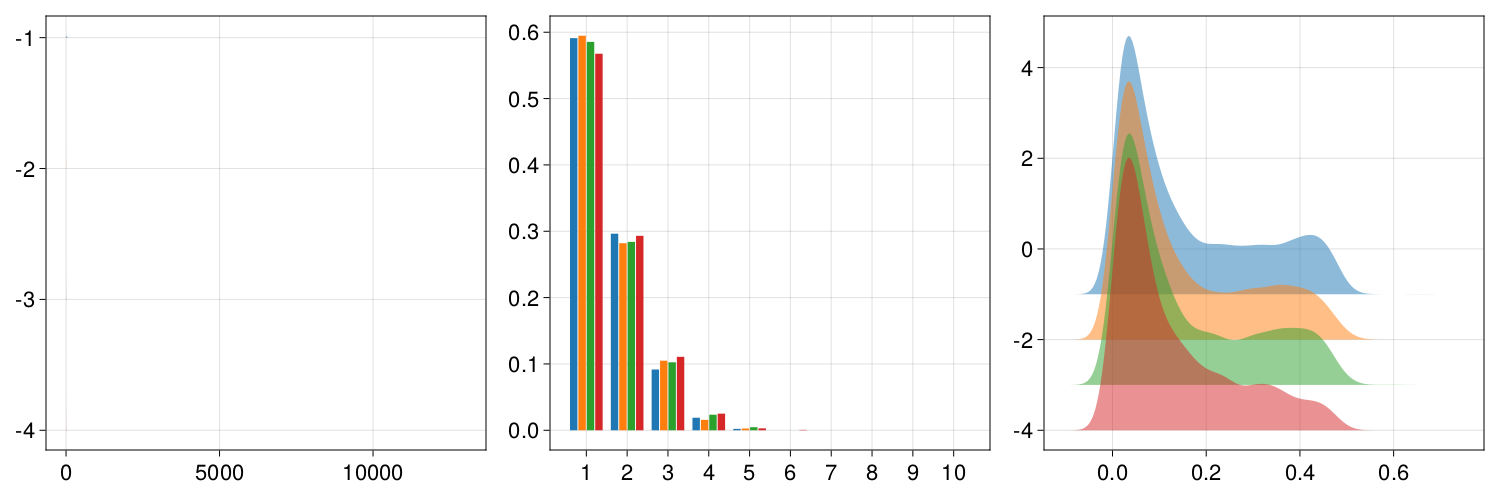

In [23]:
fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
ax3 = Axis(fig[1,3])

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for i in unique(clust_labels)

    r = condition_data((:mut_size,:fitness_delta),[:cluster_id],[i],all_mut_info)
    r_ms1 = reduce(vcat,map(x->sum(x .* x),r[:mut_size]));
    r_ms2 = reduce(vcat,map(x->length(x),r[:mut_size]));

    r_ms2_cm = countmap(r_ms2)

    count_v = zeros(10)

    for nm in 1:10
        if haskey(r_ms2_cm,nm)
            count_v[nm] = r_ms2_cm[nm]
        else
            count_v[nm] = 0
        end
    end

    count_v = count_v ./ sum(count_v)

    r_ms3 = reduce(vcat,r[:fitness_delta]);

    CairoMakie.density!(ax1,r_ms1, color = (color_scheme[i],0.5),offset = -i)

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(i) for _ in 1:10])
    push!(pos_list,collect(1:10))
    push!(color_list,[color_scheme[i] for _ in 1:10])

    CairoMakie.density!(ax3,r_ms3, color = (color_scheme[i],0.5),offset = -i)
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax2,xs,ys,dodge = dodge, color = bar_cl)
ax2.xticks = (1:10,string.(1:10))

fig

In [24]:
all_mut_info[1]

(traj_id = 1, cluster_id = 1, fitness_delta = 0.4476011677101961, fitness_bin = 1, fitness = 0.0014834054265424304, mut_size = [0.9513223171708831], n_mut = 1, mut_id_name = "C=>C", mut_id = [9])

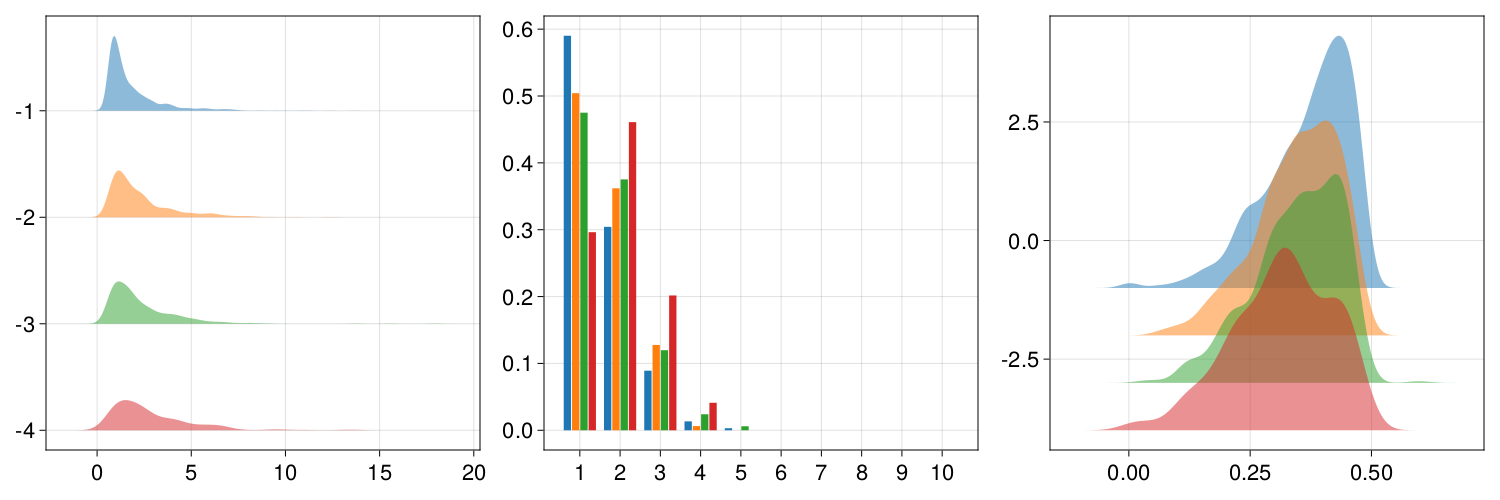

In [25]:
# r = condition_data((:mut_size,:fitness_delta,:cluster_id),[:fitness_bin],[1],all_mut_info)

fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
ax3 = Axis(fig[1,3])

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for i in unique(clust_labels)

    r = condition_data((:mut_size,:fitness_delta),[:cluster_id,:fitness_bin],[i,1],all_mut_info)
    r_ms1 = reduce(vcat,map(x->sum(x .* x),r[:mut_size]));
    r_ms2 = reduce(vcat,map(x->length(x),r[:mut_size]));

    r_ms2_cm = countmap(r_ms2)

    count_v = zeros(10)

    for nm in 1:10
        if haskey(r_ms2_cm,nm)
            count_v[nm] = r_ms2_cm[nm]
        else
            count_v[nm] = 0
        end
    end

    count_v = count_v ./ sum(count_v)

    r_ms3 = reduce(vcat,r[:fitness_delta]);

    CairoMakie.density!(ax1,r_ms1, color = (color_scheme[i],0.5),offset = -i)

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(i) for _ in 1:10])
    push!(pos_list,collect(1:10))
    push!(color_list,[color_scheme[i] for _ in 1:10])

    CairoMakie.density!(ax3,r_ms3, color = (color_scheme[i],0.5),offset = -i)
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax2,xs,ys,dodge = dodge, color = bar_cl)
ax2.xticks = (1:10,string.(1:10))

fig

In [26]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 30.)

weight_indices = Tuple.(findall(viable_mutations .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:length(weight_indices)

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Weight Value", ylabel="Fitness", title = weight_names[wi]) 

    for cl in unique(clust_labels)
        r = condition_data_incl((:mut_size,:mut_id),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)
        r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]
        CairoMakie.density!(ax1,r_ms,color = (color_scheme[cl],0.5))
    end

    push!(ax_list,ax1)

end

# linkxaxes!(ax_list...)
# linkyaxes!(ax_list...)

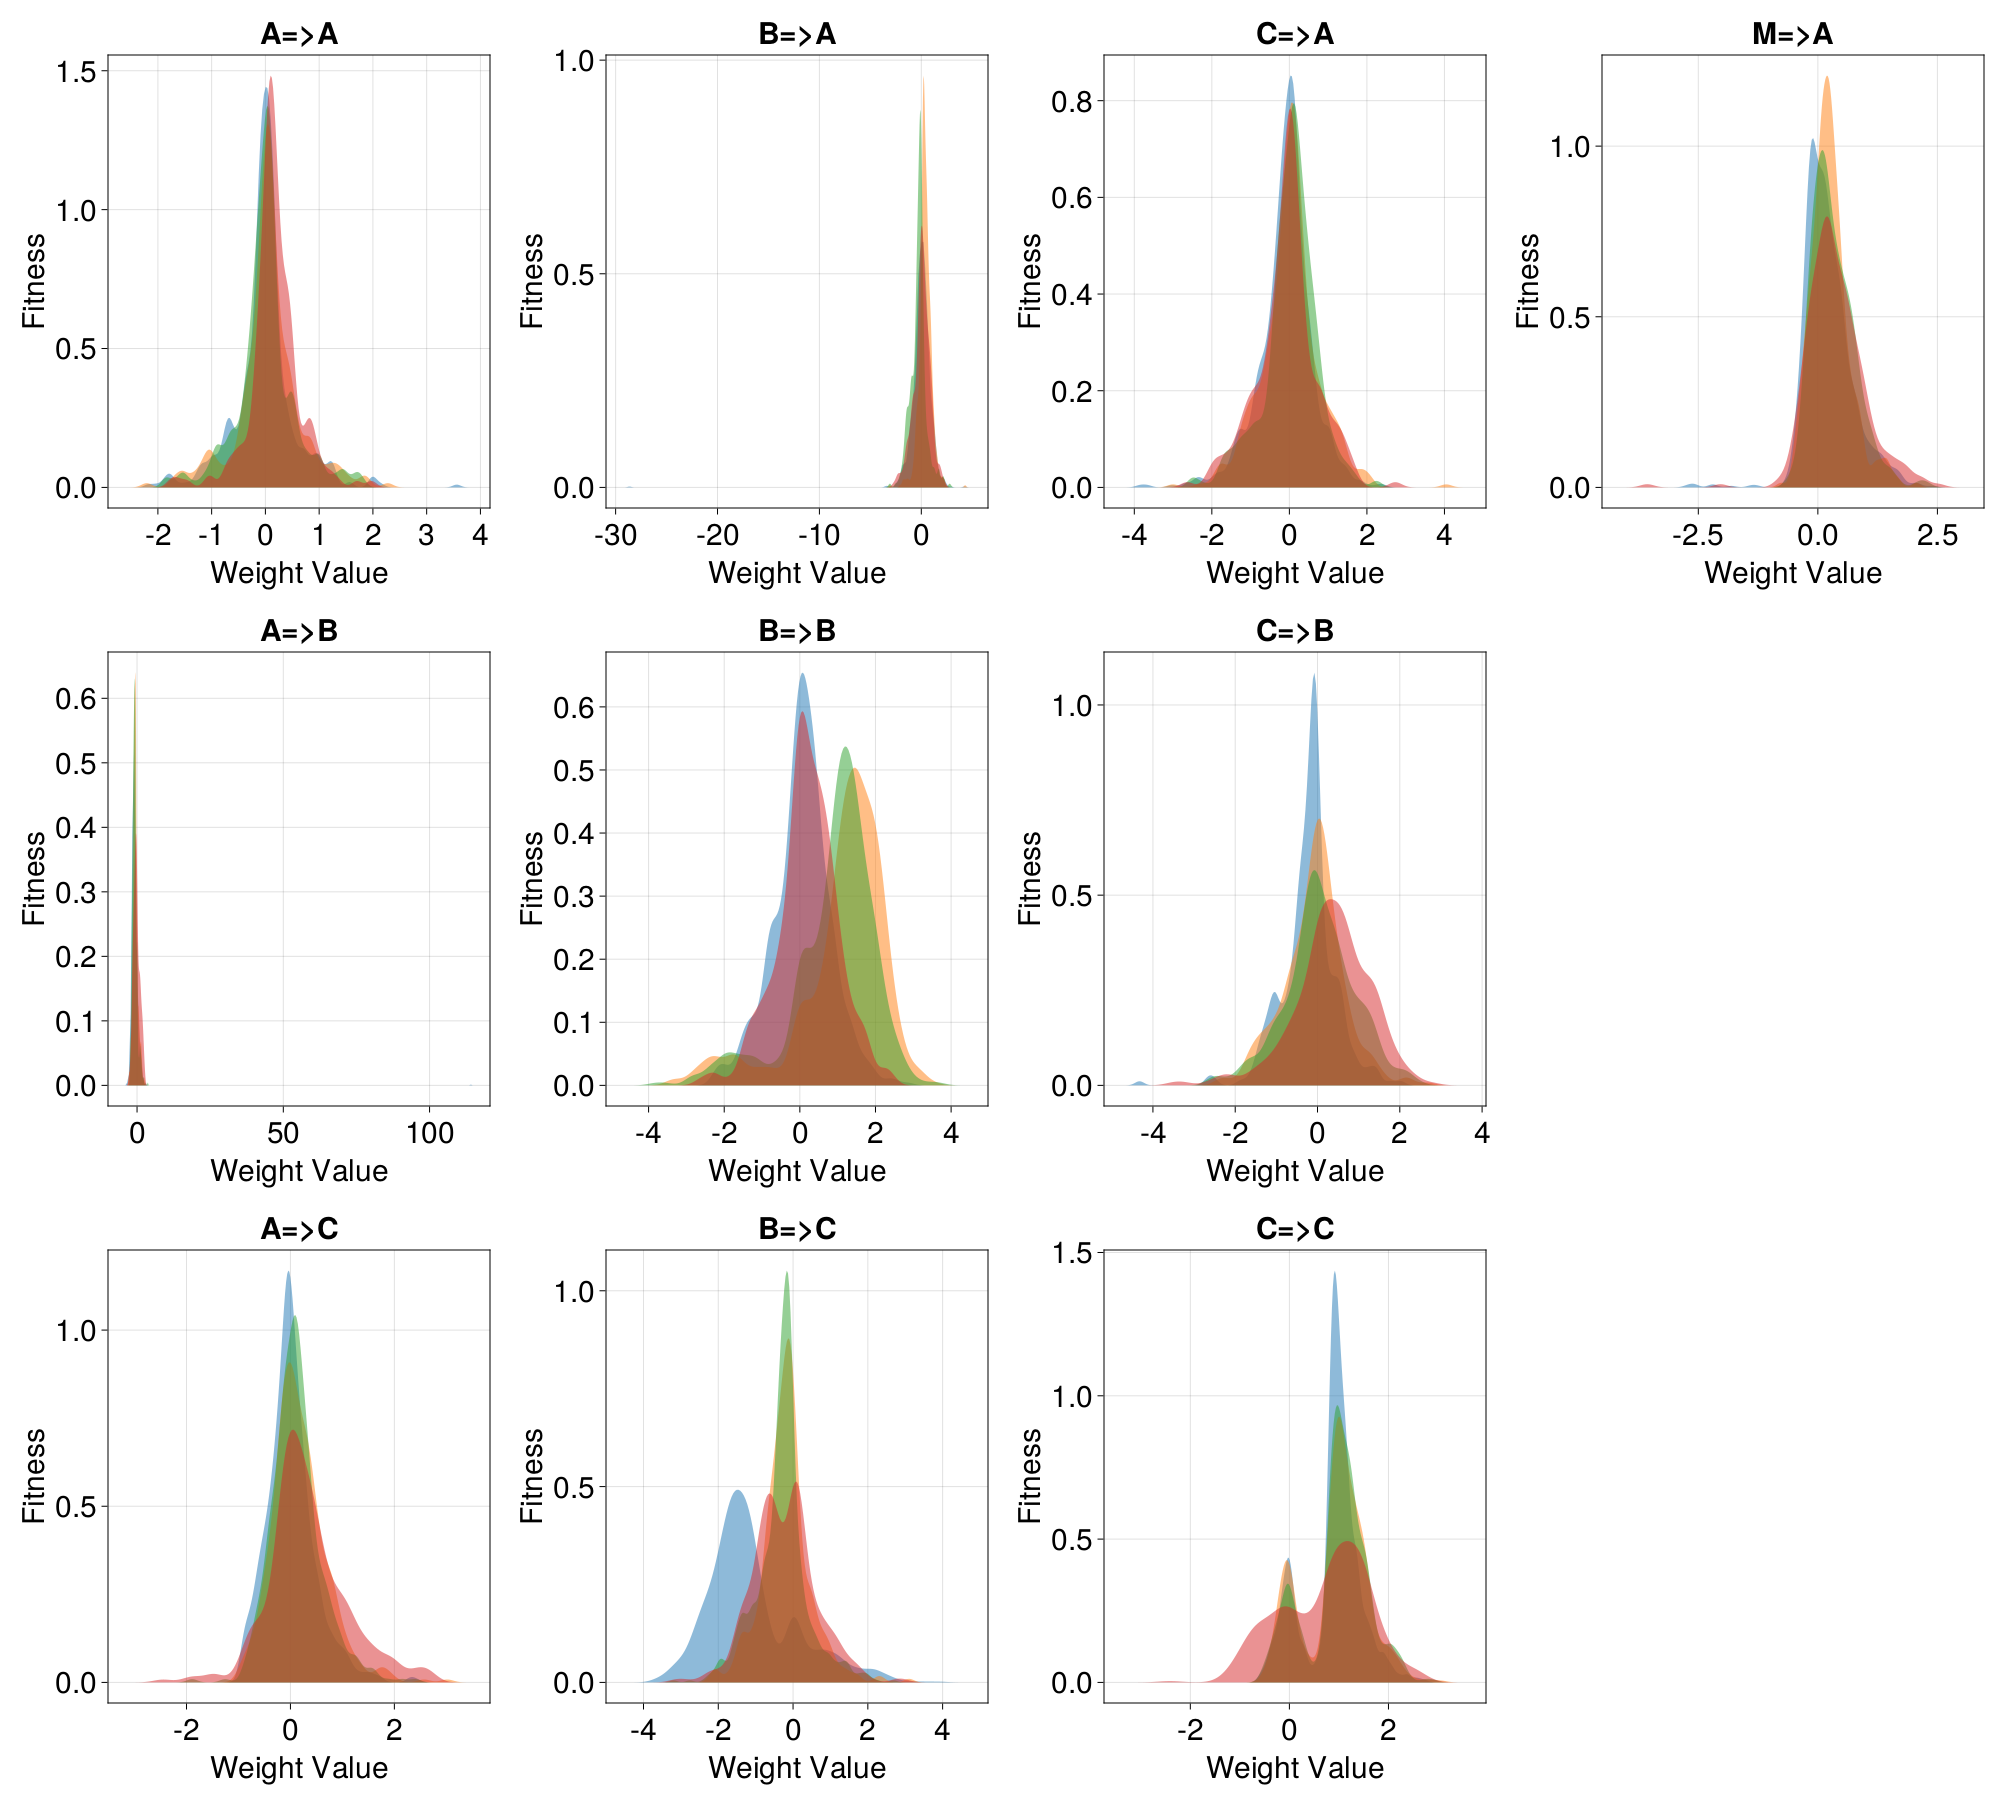

In [27]:
fig


In [28]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 30.)

weight_indices = Tuple.(findall(viable_mutations .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:length(weight_indices)

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Weight Value", ylabel="Fitness", title = weight_names[wi]) 

    for cl in unique(clust_labels)
        r = condition_data_incl((:mut_size,:mut_id),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)
        r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]
        CairoMakie.density!(ax1,r_ms,color = (color_scheme[cl],0.5))
    end

    push!(ax_list,ax1)

end

# linkxaxes!(ax_list...)

In [29]:
a = rand(10,10)

a[a.<0.5] .= 0

a

10×10 Matrix{Float64}:
 0.898947  0.625603  0.528478  0.549985  …  0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.714374  0.94662
 0.0       0.924385  0.509853  0.0          0.631927  0.910877  0.887813
 0.627077  0.0       0.0       0.509889     0.880443  0.968864  0.0
 0.686651  0.0       0.744336  0.0          0.0       0.963447  0.0
 0.0       0.911673  0.939526  0.0       …  0.856089  0.0       0.782674
 0.826065  0.925404  0.0       0.84924      0.607159  0.0       0.628674
 0.0       0.88125   0.0       0.0          0.782856  0.0       0.0
 0.0       0.909926  0.92348   0.636622     0.0       0.0       0.745732
 0.963074  0.672672  0.0       0.630678     0.0       0.639238  0.0

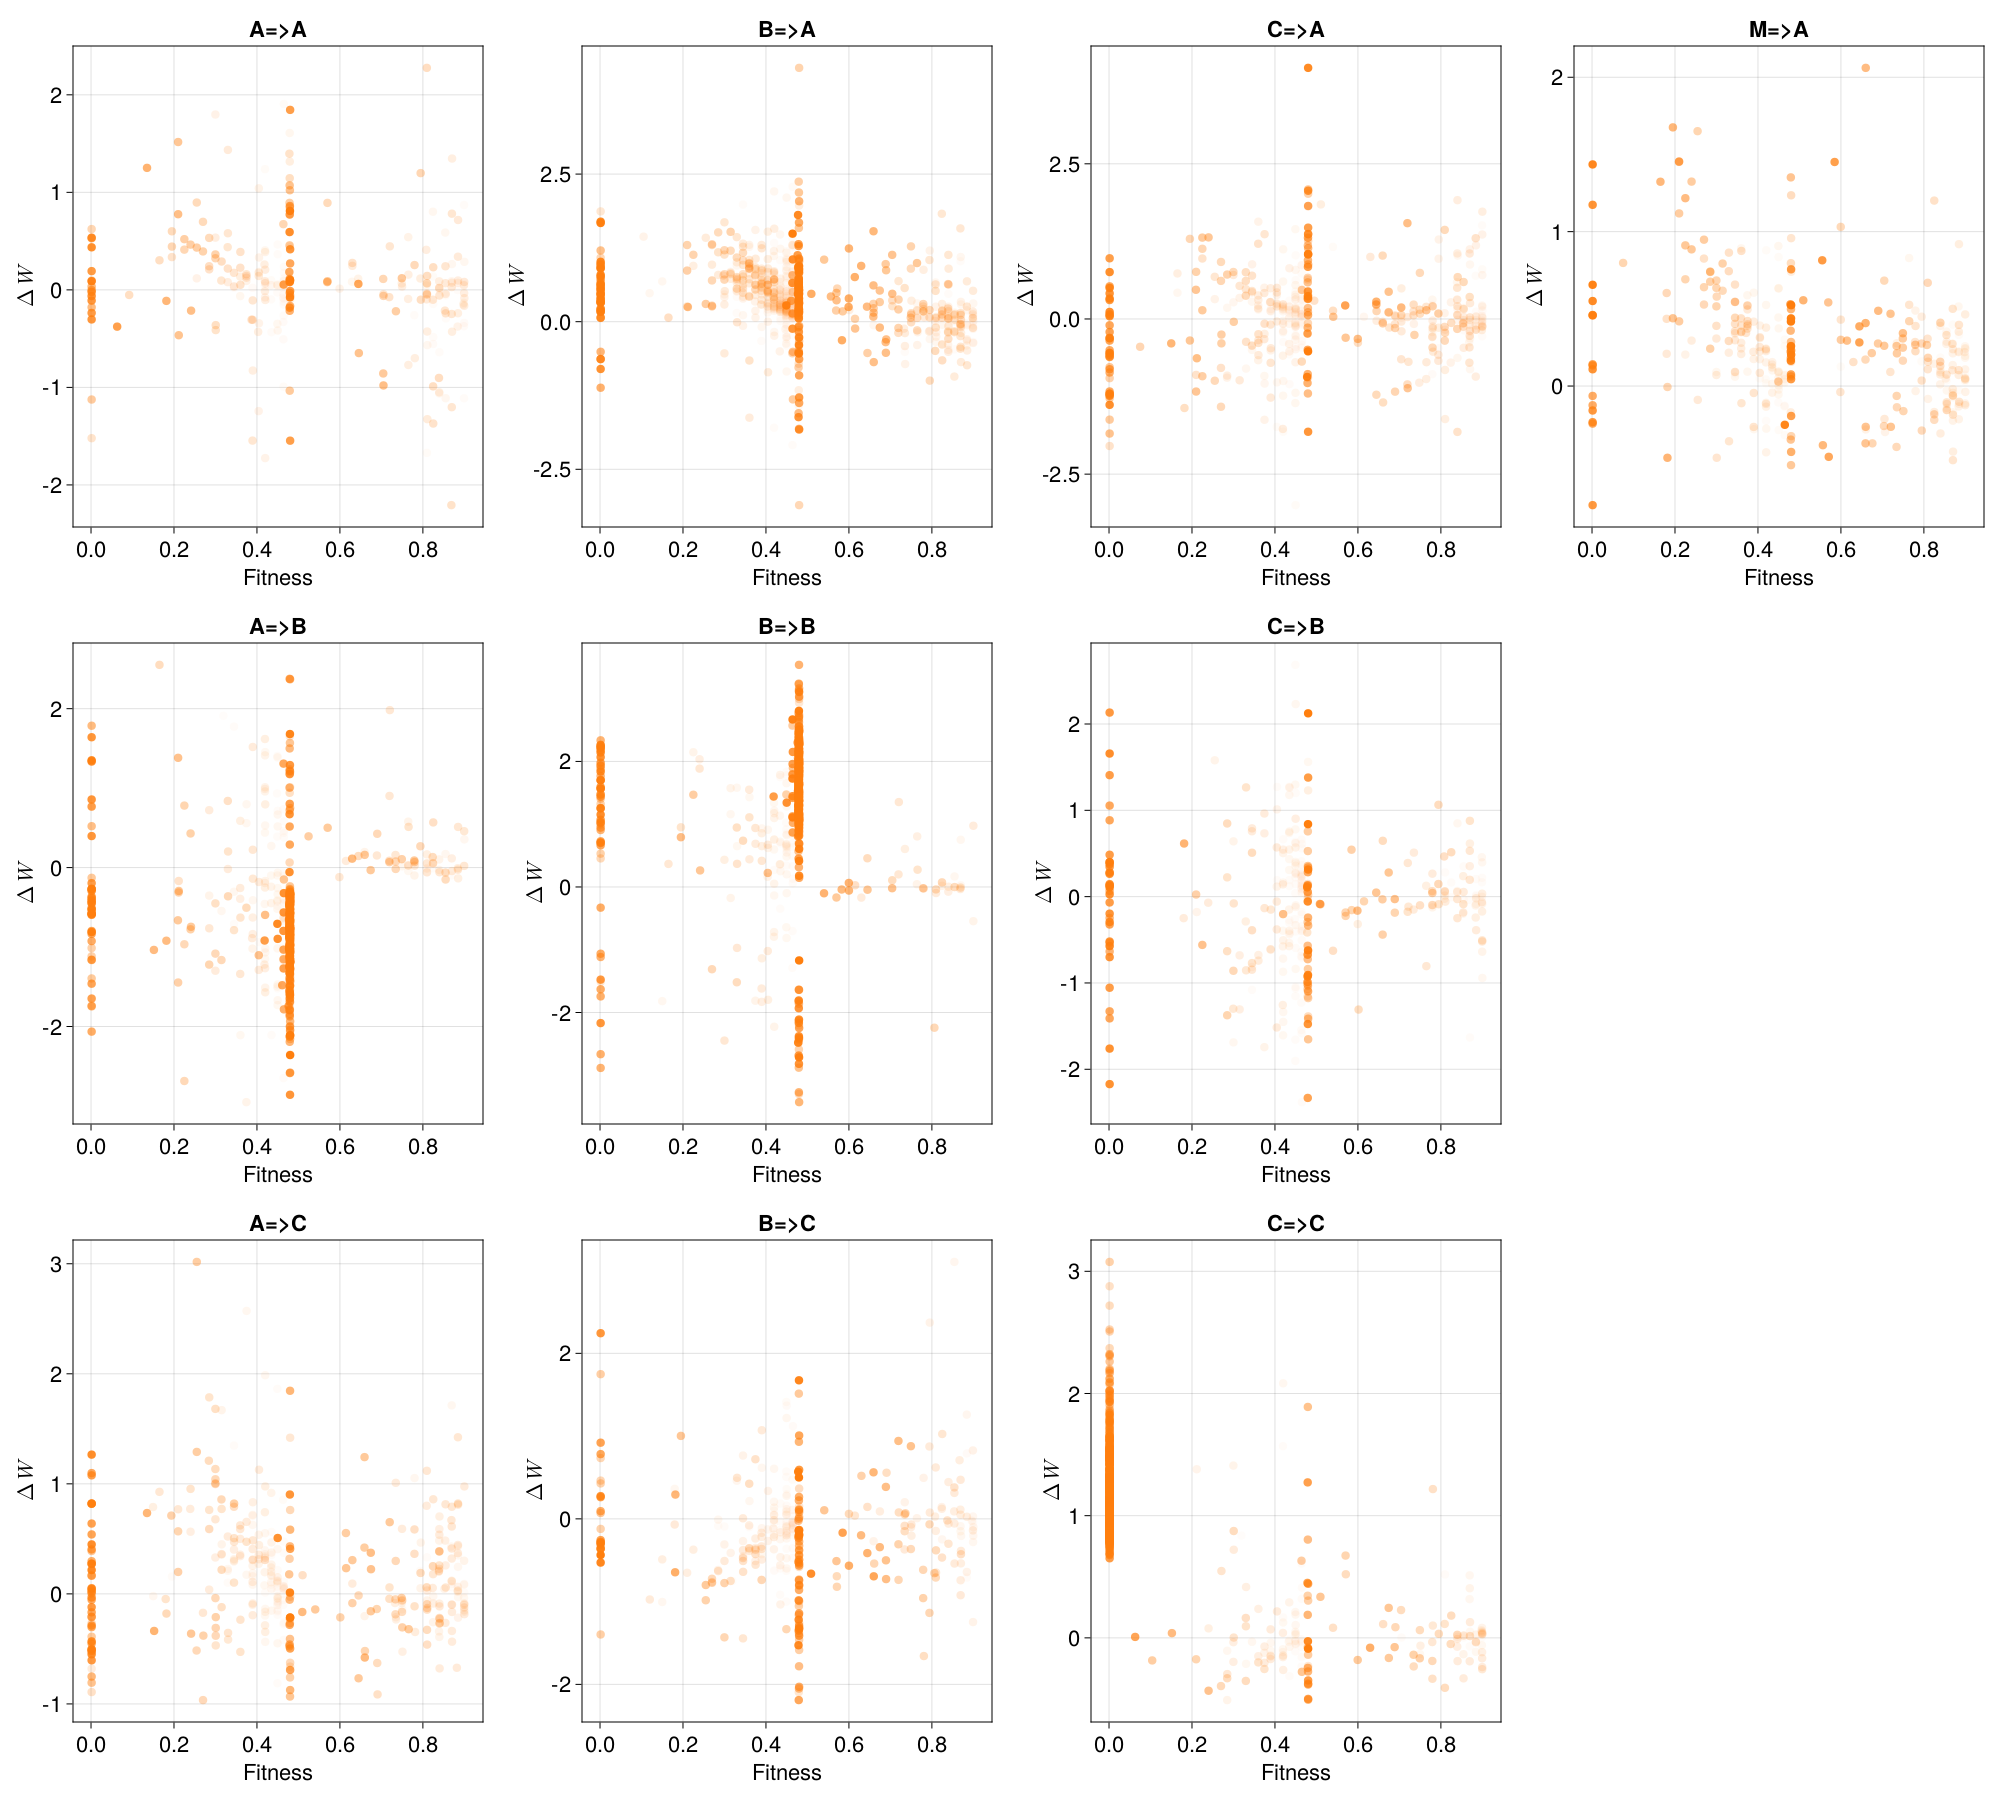

In [30]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

cl = 2

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Fitness", ylabel=L"\Delta W", title = weight_names[wi])

    r = condition_data_incl((:mut_size,:mut_id,:cluster_id,:fitness,:fitness_delta),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)
    r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]

    r_cl = reduce(vcat,r[:cluster_id]);
    r_fitness = reduce(vcat,r[:fitness]);
    r_fitness_delta = reduce(vcat,r[:fitness_delta]);

    color_cl = map(x->color_scheme[x],r_cl)

    CairoMakie.scatter!(ax1,r_fitness,r_ms,color = [(c,o) for (c,o) in zip(color_cl,r_fitness_delta/maximum(r_fitness_delta))])
    # CairoMakie.scatter!(ax1,r_fitness,r_ms,color = color_cl)

    push!(ax_list,ax1)

end

linkxaxes!(ax_list...)

fig

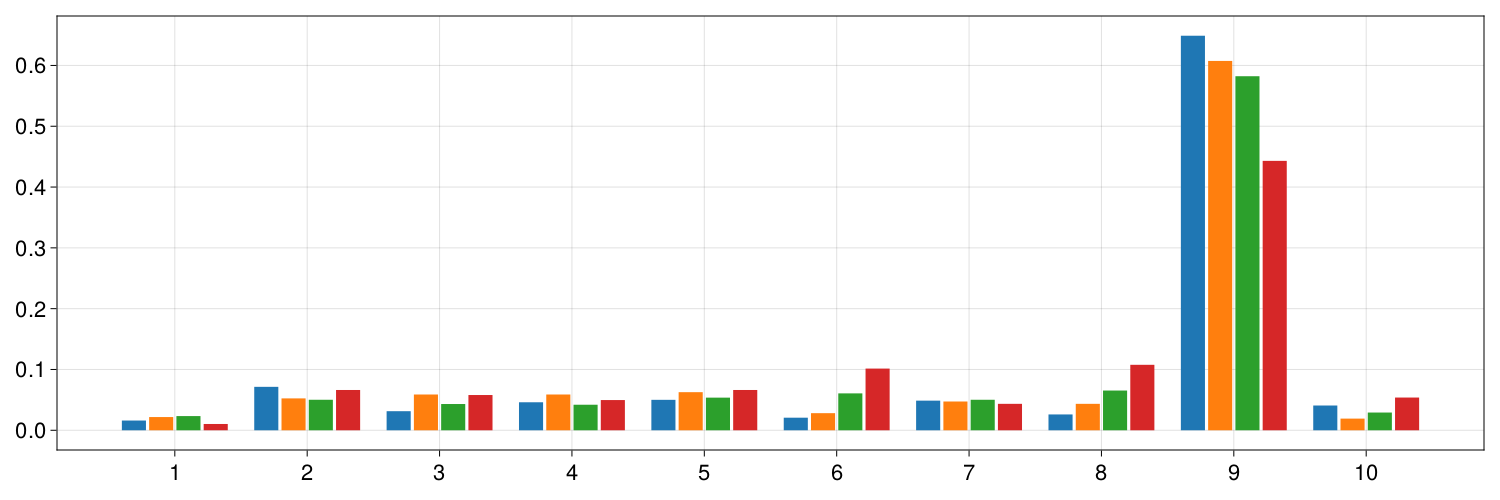

In [31]:
# r = condition_data_incl((:traj_id),[:fitness_bin],[1],[:mut_id],[wi],all_mut_info)
# n_traj = length(unique(reduce(vcat,r[:traj_id])))


fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
ax1 = Axis(fig[1,1])


count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for i in unique(clust_labels)

    count_v = zeros(10)

    for wi in 1:10
        r = condition_data_incl((:fitness,:traj_id),[:fitness_bin,:cluster_id],[1,i],[:mut_id],[wi],all_mut_info)
        rnf = condition_data((:fitness,:traj_id),[:fitness_bin,:cluster_id],[1,i],all_mut_info)
        count_v[wi] = length(unique(reduce(vcat,r[:traj_id]))) / length(unique(reduce(vcat,rnf[:traj_id])))
    end

    count_v = count_v ./ sum(count_v)

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(i) for _ in 1:10])
    push!(pos_list,collect(1:10))
    push!(color_list,[color_scheme[i] for _ in 1:10])
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax1,xs,ys,dodge = dodge, color = bar_cl)
ax1.xticks = (1:10,string.(1:10))

fig


In [32]:
r = condition_data((:fitness,:traj_id,:mut_id),[:fitness_bin],[1],all_mut_info);

In [33]:
r[:traj_id]

2198-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
    ⋮
 2190
 2191
 2192
 2193
 2194
 2195
 2196
 2197
 2198

In [34]:
sim_fm = map(x->length(x) == 1 ? x[1] : 0,r[:mut_id]);

In [35]:
unique(reshape(sim_fm[hc1.order],(1,n_traj)))

3-element Vector{Int64}:
 0
 9
 6

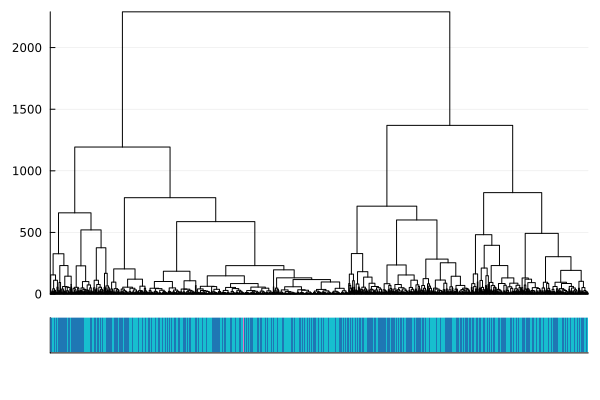

In [36]:
hc1 = hclust(dmat_av[conv,conv],linkage = :ward)

p1 = StatsPlots.plot(hc1,xticks = false,label = nothing)

p2 = StatsPlots.heatmap(reshape(sim_fm[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab10,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [37]:
# # result = zeros(10,n_bin-1)

# result = zeros(10,length(unique(clust_labels)))

# r_ms_list = []

# for wi in 1:10
#     for cl in unique(clust_labels)

#         r = condition_data_incl((:mut_size,:mut_id,:fitness_delta,:fitness,:cluster_id),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)

#         r_fitness_delta = reduce(vcat,r[:fitness_delta]);

#         label = reduce(vcat,r[:cluster_id])

#         r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]

#         test_p = pvalue(ExactOneSampleKSTest(r_ms, mutation_op.noise_distribution))

#         result[wi,cl] = test_p

#         push!(r_ms_list,r_ms)
#     end
# end

In [38]:
# using PyCall

# phate = pyimport("phate")

# phate_op = phate.PHATE(k = 100,n_jobs = -2, gamma=0)

# rescale(A; dims=1) = (A .- mean(A, dims=dims)) ./ max.(std(A, dims=dims), eps())

# # X = rescale(data["dmat_X_av"][:,conv] |> transpose |> collect, dims=1);

# X = data["dmat_X_av"][:,conv] |> transpose |> collect

# phate_pheno_g3 = phate_op.fit_transform(X);

# fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

# ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING")

# c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5., color = clust_labels,colormap = cgrad(:tab20,categorical = true))

# Colorbar(fig[1,2], c)

# fig